In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
import imutils
from os import listdir
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [17]:
from os import listdir

def data_summary(main_path):

    yes_path = main_path + '/yes'
    no_path = main_path + '/no'

    m_pos = len(listdir(no_path))
    m_neg = len(listdir(yes_path))

    m = m_pos + m_neg

    pos_prec = (m_pos * 100.0) / m
    neg_prec = (m_neg * 100.0) / m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of positive examples: {m_pos}")
    print(f"Percentage of negative examples: {neg_prec}%, number of negative examples: {m_neg}")

# Define the path to your augmented data directory
augmented_data_path = '/content/drive/My Drive/BRAIN/dataset/augmented_data'

# Call the function with the specified path
data_summary(augmented_data_path)


Number of examples: 4248
Percentage of positive examples: 54.33145009416196%, number of positive examples: 2308
Percentage of negative examples: 45.66854990583804%, number of negative examples: 1940


In [18]:
def crop_brain_contour(image, plot=False):


    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)


    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

In [19]:
# Here we create a dict which consists label for each image path and its particular data.
def load_file(file_path, label):

    # declare the folder name
    folder_name = file_path.split("/")[-1]
    # declare output list
    out_list = []
    # load every file that .png format
    for image_path in glob.glob(file_path + "/*.*"):
        # read image file
        image = imageio.imread(image_path)
        # declare temporary dict dtype
        temp = {}
        # set the file name
        temp["name"] = image_path.split("/")[-1]
        # set the file label, 0 for non defect. 1 for defect
        temp["label"] = label

        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:
            temp["data"] = image[:,:,0].astype("int")
        except:
            # normal case
            temp["data"] = image.astype("int")
        # append temp into output list
        out_list.append(temp)
    # print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))
    # convert list into numpy array dtype
    return np.array(out_list)

In [20]:
non_tumor_images_path=  r"/content/drive/My Drive/BRAIN/dataset/augmented_data/no"
tumor_images_path =  r"/content/drive/My Drive/BRAIN/dataset/augmented_data/yes"

In [21]:
defect_images = load_file(file_path=tumor_images_path, label=1)
non_defect_images = load_file(file_path=non_tumor_images_path, label=0)

loading file from folder: yes is successful
loading file from folder: no is successful


In [22]:
np.random.shuffle(non_defect_images)
np.random.shuffle(defect_images)

# the class size is the min length compared with defect-free and defect images, we do this in orde to balance the dataset.
if defect_images.shape[0] <= non_defect_images.shape[0]:
  class_size = defect_images.shape[0]
else:
  class_size = non_defect_images.shape[0]
print("Class Size:", class_size)

Class Size: 1940


In [23]:
# we shuffle the order of defect-free and defect images
np.random.shuffle(non_defect_images)
np.random.shuffle(defect_images)

# the class size is the min length compared with defect-free and defect images, we do this in orde to balance the dataset.
if defect_images.shape[0] <= non_defect_images.shape[0]:
  class_size = defect_images.shape[0]
else:
  non_defect_images.shape[0]
print("Class Size:", class_size)

# Concatenate both the datasets with size as class_size.
dataset = np.concatenate((defect_images[:class_size], non_defect_images[:class_size]))

# create an empty matrix X of 256x4096 and has dataset length row, which holds all the data i.e images from dataset.
# Independent Features -> X
X = np.empty([dataset.shape[0], 255, 255]).astype(int)

# create vector y which has dataset length, which holds all the labels for our data, this is jsut similar to partitioning the data before splitting,
# Target_variable -> y
y = np.empty(dataset.shape[0]).astype(int)

# assign the X,y one-by-one
for i in range(dataset.shape[0]):
    X[i] = dataset[i]["data"]
    y[i] = dataset[i]["label"]

# since Keras acquire the Image input in a tensor type -> we reshape X
X = X.reshape(X.shape[0], 255, 255, 1)
print(X.shape)

# display size of the label 0 and label 1
np.unique(y, return_counts=True)

Class Size: 1940


<ipython-input-23-df3a678af3cc>:21: RuntimeWarning: invalid value encountered in cast
  y = np.empty(dataset.shape[0]).astype(int)


(3880, 255, 255, 1)


(array([0, 1]), array([1940, 1940]))

In [24]:
def plot_sample_images(X, y, n=50):


    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

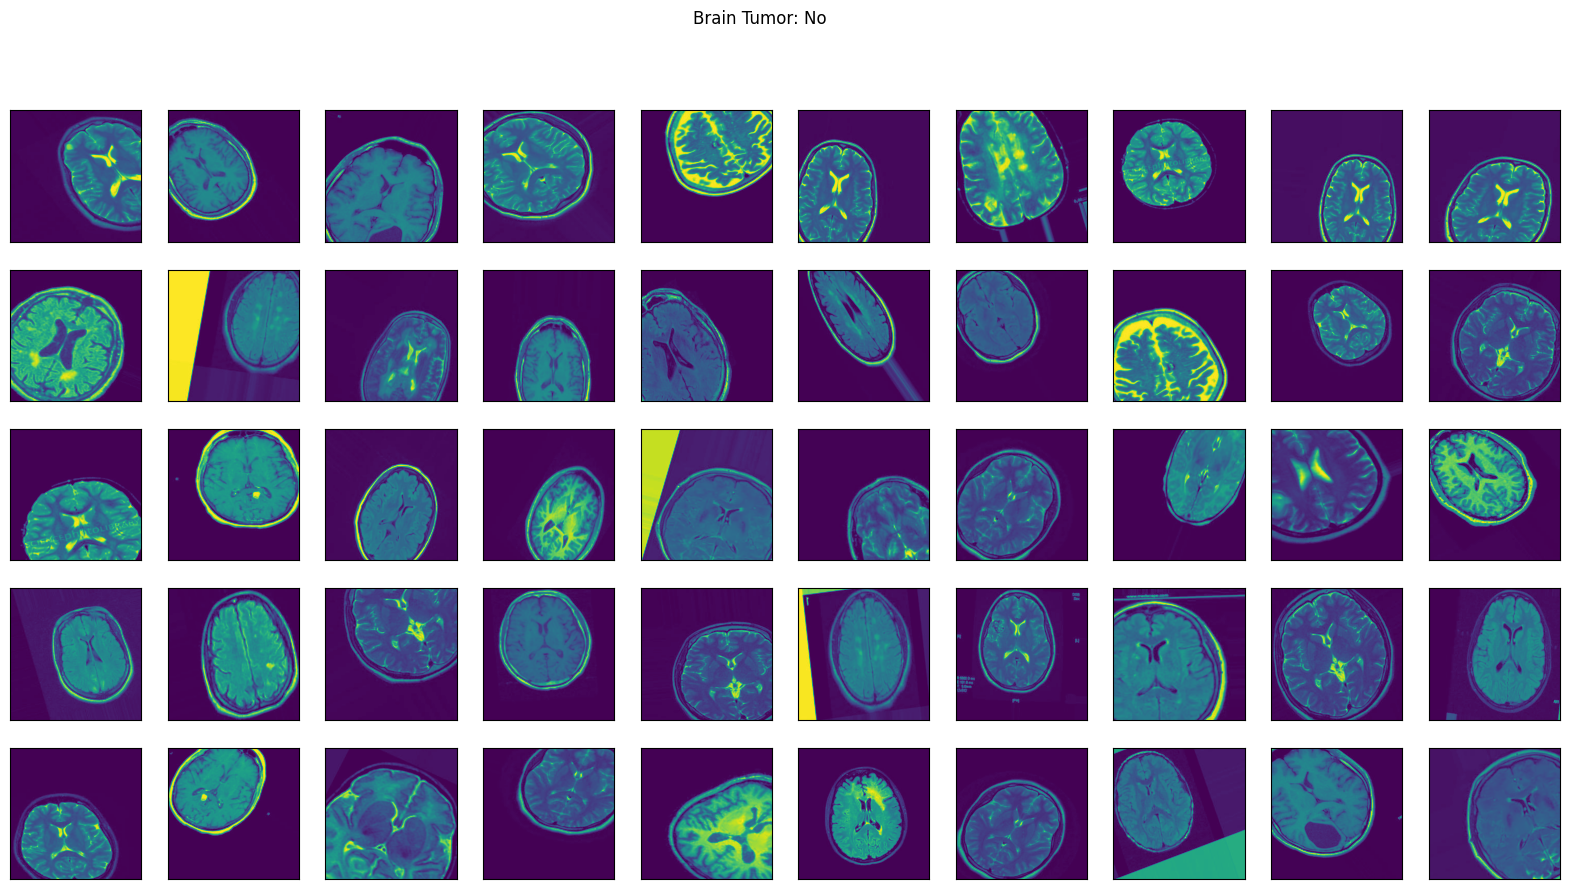

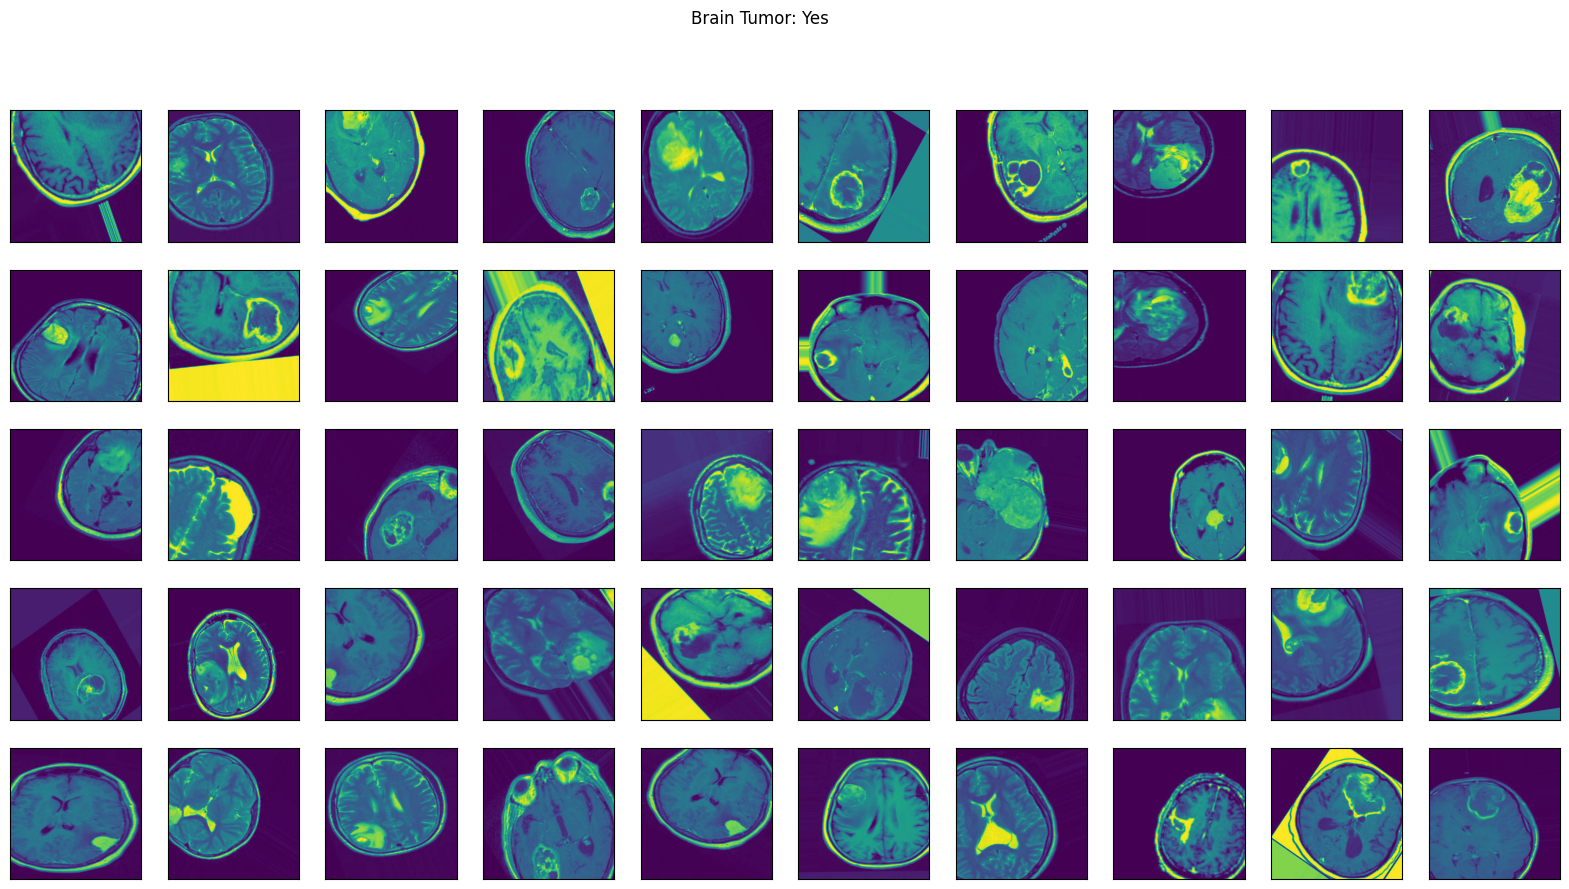

In [70]:
plot_sample_images(X, y)

In [25]:
def create_model(image_shape=(256, 4096, 1), print_summary=True):
    # initial model
    model = models.Sequential()

    # CONV layer: filter 16, stride 7x7
    model.add(layers.Conv2D(16, (7, 7),input_shape=image_shape))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))


    # CONV layer: filter 32, stride 5x5
    model.add(layers.Conv2D(32, (5, 5), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))

    # CONV layer: filter 64, stride 5x5
    model.add(layers.Conv2D(64, (5, 5), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))



    # flatten layer -> To convert from matrix to vector ie from multidimensional array to 1D array with single column.
    model.add(layers.Flatten())


    # Here we are creating an actual neural network which takes input as the flatten layer.
    # fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(64))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))

    # Here we are creating an actual neural network which takes input as the flatten layer.
    # fully connected layer -> nn layer with 12 nodes
    model.add(layers.Dense(32))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))

    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))


    # set model compiler
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    # show the CNN model detail
    if print_summary:
        model.summary()
    return model

def train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size):
    # train CNN model
    # batch size to reduce memory usage
    # set early stopping to avoid overfitting

    earlystopping = EarlyStopping(monitor='val_accuracy', patience=2)
    filepath = "A:/TechieYan projects/MIX/Lung Cancer/model/model/weights-best-{epoch:02d}-{val_accuracy:.2f}.hdf5"

    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, earlystopping]

    history = model.fit(xtrain, ytrain, epochs=n_epoch, batch_size=batch_size, validation_data=(xval, yval), callbacks=[callbacks_list])
    return history

create_model(image_shape=(255, 255, 1), print_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 16)      800       
                                                                 
 batch_normalization (Batch  (None, 249, 249, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 249, 249, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 124, 124, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      1

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=23)
print("X_train: number of samples each class: {}".format(np.unique(y_train, return_counts=True)))
print("X_test: number of samples each class: {}".format(np.unique(y_test, return_counts=True)))

X_train: number of samples each class: (array([0, 1]), array([1765, 1727]))
X_test: number of samples each class: (array([0, 1]), array([175, 213]))


In [27]:
cnn_model = None
cnn_model = create_model(image_shape=(255, 255, 1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 249, 249, 16)      800       
                                                                 
 batch_normalization_5 (Bat  (None, 249, 249, 16)      64        
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 249, 249, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 124, 124, 16)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 124, 124, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 32)     

In [28]:
earlystopping = EarlyStopping(monitor='val_accuracy', patience=4)
filepath = "/content/drive/My Drive/BRAIN/model/weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, earlystopping]

In [ ]:
cnn_model.fit(X_train, y_train, batch_size=10, epochs=10, validation_split=0.1, callbacks=callbacks_list)

Epoch 1/10
315/315 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.6292
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to /content/drive/My Drive/BRAIN/model/weights_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


315/315 [==============================] - 504s 2s/step - loss: 0.6529 - accuracy: 0.6292 - val_loss: 0.8192 - val_accuracy: 0.5200
Epoch 2/10
315/315 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.6894
Epoch 2: val_accuracy improved from 0.52000 to 0.65143, saving model to /content/drive/My Drive/BRAIN/model/weights_best.hdf5
315/315 [==============================] - 504s 2s/step - loss: 0.5959 - accuracy: 0.6894 - val_loss: 0.6012 - val_accuracy: 0.6514
Epoch 3/10
315/315 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.7177
Epoch 3: val_accuracy did not improve from 0.65143
315/315 [==============================] - 498s 2s/step - loss: 0.5533 - accuracy: 0.7177 - val_loss: 0.7368 - val_accuracy: 0.6114
Epoch 4/10
315/315 [==============================] - ETA: 0s - loss: 0.5202 - accuracy: 0.7349
Epoch 4: val_accuracy improved from 0.65143 to 0.75143, saving model to /content/drive/My Drive/BRAIN/model/weights_best.hdf5
315/315 [====

In [36]:
score, acc = cnn_model.evaluate(X_test, y_test, verbose=0)
score, acc

(0.6064323782920837, 0.75)

In [37]:
def plot_metrics(history):

    train_loss = history['loss']
    train_acc = history['accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [38]:
xi = np.array(X_test[73]).reshape(-1, 255, 255, 1)
print(xi.shape)

(1, 255, 255, 1)


In [41]:
new = tf.keras.models.load_model("/content/drive/My Drive/BRAIN/model/weights_best.hdf5")
y_pred = new.predict(xi)
y_pred
if y_pred > 0.5:
    y_pred = 1
    print("The Person is having Brain Tumor.")
else:
    y_pred = 0
    print("The Person is not having Brain Tumor.")

1/1 [==============================] - 1s 661ms/step
The Person is not having Brain Tumor.


In [42]:
y_pred = new.predict(X_test)
y_pred

3/3 [==============================] - 5s 2s/step


array([[0.5004194 ],
       [0.05235349],
       [0.6327431 ],
       [0.00877048],
       [0.08114605],
       [0.18304874],
       [0.62754124],
       [0.01593284],
       [0.6877912 ],
       [0.18865216],
       [0.27318195],
       [0.07985362],
       [0.9324862 ],
       [0.86039865],
       [0.4590385 ],
       [0.7741763 ],
       [0.36706838],
       [0.02762841],
       [0.39311323],
       [0.8495305 ],
       [0.15980239],
       [0.4296992 ],
       [0.3528201 ],
       [0.83176816],
       [0.1387902 ],
       [0.5534998 ],
       [0.60929585],
       [0.01792816],
       [0.00469582],
       [0.77829736],
       [0.5714318 ],
       [0.44410968],
       [0.68435353],
       [0.31133527],
       [0.6690334 ],
       [0.27269676],
       [0.24430078],
       [0.28748584],
       [0.04224159],
       [0.01607873],
       [0.52141774],
       [0.3205531 ],
       [0.7070104 ],
       [0.42124373],
       [0.00755026],
       [0.9265164 ],
       [0.914542  ],
       [0.411

In [43]:
count = len(y_pred)
for i in range(count):
    if y_pred[i] > 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

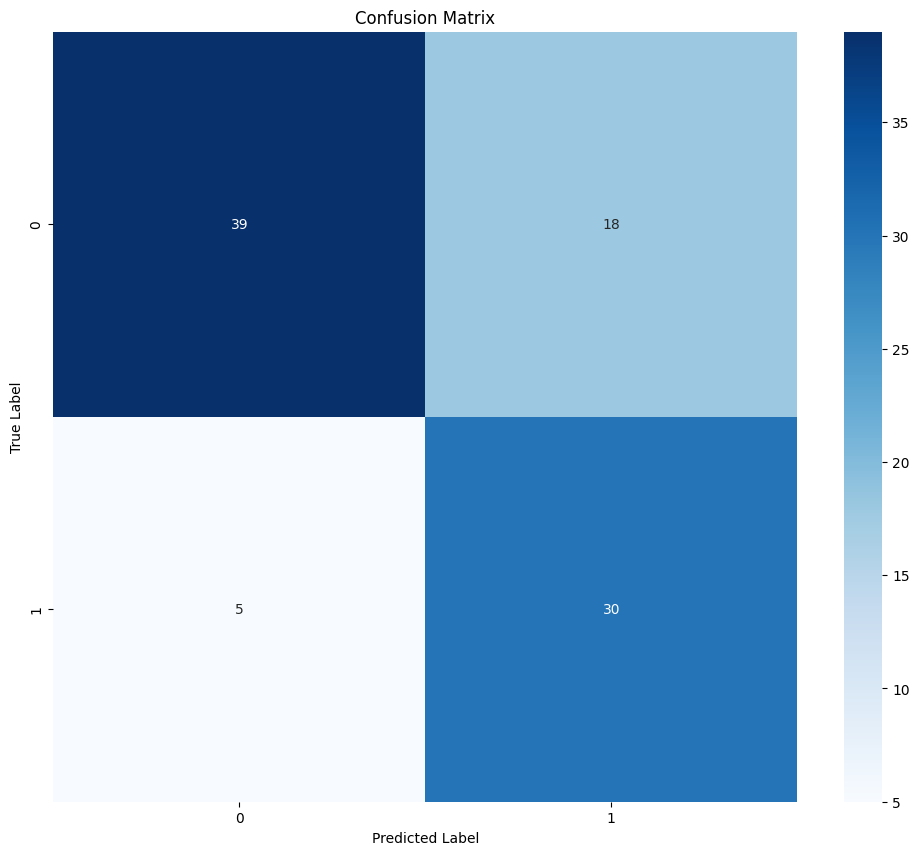

In [44]:
    plt.figure(figsize = (12,10))
    cf_matrix = confusion_matrix(y_pred,y_test)
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [45]:
import tkinter as tk
from tkinter import *
from tkinter.ttk import *
from tkinter.filedialog import askopenfile
from tkinter import messagebox
import time
import cv2
import imageio
from tensorflow.keras.preprocessing.image import img_to_array
import threading
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageTk

root = tk.Tk()
root.title('Brain Tumor Detection using CNN')
root.geometry("1200x600")

def open_file():
    global file_path
    file_path = askopenfile(mode='r', filetypes=[('Files', '*.*')])
    print(file_path.name)
    if file_path is not None:
        pass

def uploadFiles():
    pb1 = Progressbar(
        root,
        orient=HORIZONTAL,
        length=300,
        mode='determinate'
        )
    pb1.pack()
    for i in range(5):
        root.update_idletasks()
        pb1['value'] += 20
        time.sleep(1)
    pb1.destroy()
    Label(root, text='File Uploaded Successfully!', foreground='green').pack()

def save_file():
    def getRawGotStr(s):
        _dRawMap = {8:r'\b', 7:r'\a', 12:r'\f', 10:r'\n', 13:r'\r', 9:r'\t', 11:r'\v'}
        return r''.join([_dRawMap.get(ord(c), c) for c in s])

    path = getRawGotStr(file_path.name)
    image_path = path
    imagee = imageio.get_reader(image_path)

    def stream(label):
        for image in imagee.iter_data():
            frame_image = ImageTk.PhotoImage(Image.fromarray(image))
            label.config(image=frame_image)
            label.image = frame_image

    my_label = tk.Label(root)
    my_label.pack()
    thread = threading.Thread(target=stream, args=(my_label,))
    thread.daemon = 1
    thread.start()

    img = plt.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    img_half = cv2.resize(img, (255, 255))
    img_half = cv2.cvtColor(img_half, cv2.COLOR_BGR2GRAY)
    x = img_to_array(img_half)
    x = np.array(x).reshape(-1, 255, 255, 1)

    prediction = model.predict(x)
    print(prediction)
    if prediction[0] > 0.5:
        print("YES")
        messagebox.showinfo("Result", "The person is having Brain Tumor")
    else:
        print("NO")
        messagebox.showerror("Result", "The person is not having Brain Tumor.")

v_d = Label(root, text="Brain Tumor Detection using CNN", font=("Times New Roman", 30), relief=SUNKEN)
v_d.pack(side=TOP, padx=1.0, pady=0.5)

choose_file_button = Button(
    root,
    text ='Choose File',
    command=lambda: open_file()
)
choose_file_button.place(x=50, y=200)

upload_file_button = Button(
    root,
    text='Upload Files',
    command=uploadFiles
)
upload_file_button.place(x=50, y=300)

path_button = Button(root, text="Click here to run the file", command=save_file)
path_button.place(x=50, y=400)

# Load the model
path_to_model = r'weights_best.hdf5'
model = tf.keras.models.load_model(path_to_model)

root.mainloop()
